In [9]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio

# Project Imports
import llops as yp
import llops.operators as ops
from llops.solvers import objectivefunctions, regularizers, iterative
import llops.simulation as sim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
ops.setDefaultBackend('numpy') # arrayfire or numpy
ops.setDefaultDatatype('complex32')

global_dtype = yp.config.default_dtype
global_backend = yp.config.default_backend

# Generate Convolutional Forward Model  with Windowing

In [11]:
# Image size to simulate
image_size = np.array([32, 64]) * 2

# Create test object
brain = sim.testObject('brain', image_size, color_channel=2, dtype=yp.getNativeDatatype(global_dtype, 'numpy'))
object_true = yp.changeBackend(brain, global_backend)

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Generate convolution kernel h
h_size = np.array([4, 4])
h = yp.zeros(image_size, global_dtype, global_backend)
h[image_size[0] // 2 - h_size[0] // 2:image_size[0] // 2 + h_size[0] // 2,
  image_size[1] // 2 - h_size[1] // 2:image_size[1] // 2 + h_size[1] // 2] = yp.randn((h_size[0], h_size[1]), global_dtype, global_backend)

h /= yp.sumb(h)

A = ops.Convolution(h, dtype=global_dtype, fft_backend='numpy', backend=global_backend, center=False, mode='circular')
y = A * yp.vectorize(object_true)

# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(np.asarray(object_true)), cmap='gray')
plt.title('Object (x)')
plt.subplot(132)
plt.imshow(np.abs(np.asarray(h)), cmap='gray')
plt.title('h')
plt.subplot(133)
plt.imshow((np.abs(np.asarray(y))).reshape(image_size), cmap='gray')
plt.title('Measurement (h * x)');

TypeError: argument of type 'type' is not iterable

# Reconstructions

In [7]:
shift_true = (2,3)

In [8]:
object_recon = np.random.rand(object_true.shape[0], object_true.shape[1]).astype(object_true.dtype)
object_recon= object_true + 0.1 * object_recon
shift_recon = np.random.rand(2).astype(np.complex64)
shift_recon = shift_true + shift_recon

## Define Bilinear Objective Function

In [9]:
H = ops.PhaseRamp(image_size)
F = ops.FourierTransform(image_size)

# Forward model which operates on object, fixing shift
D_shift = ops.Diagonalize((H * shift_recon).reshape(image_size), label='D{shift}')
A_object = F.H * D_shift * F
A_object_set_shift = lambda shift: A_object.setArgument(H * np.asarray(shift).astype(np.complex64), label='D{shift}')

# Forward model which operates on shift, fixing object
D_object = ops.Diagonalize((F * object_recon.reshape(-1)).reshape(image_size), label='D{object}')
A_shift = F.H * D_object * H
A_shift_set_object = lambda object_update: A_shift.setArgument(F * object_update.astype(np.complex64).reshape(-1), label='D{object}')

ValueError: Input data type mismatch, for <8192x2 PhaseRamp NUMPY Operator with dtype=complex32>, got complex64

<IPython.core.display.Javascript object>


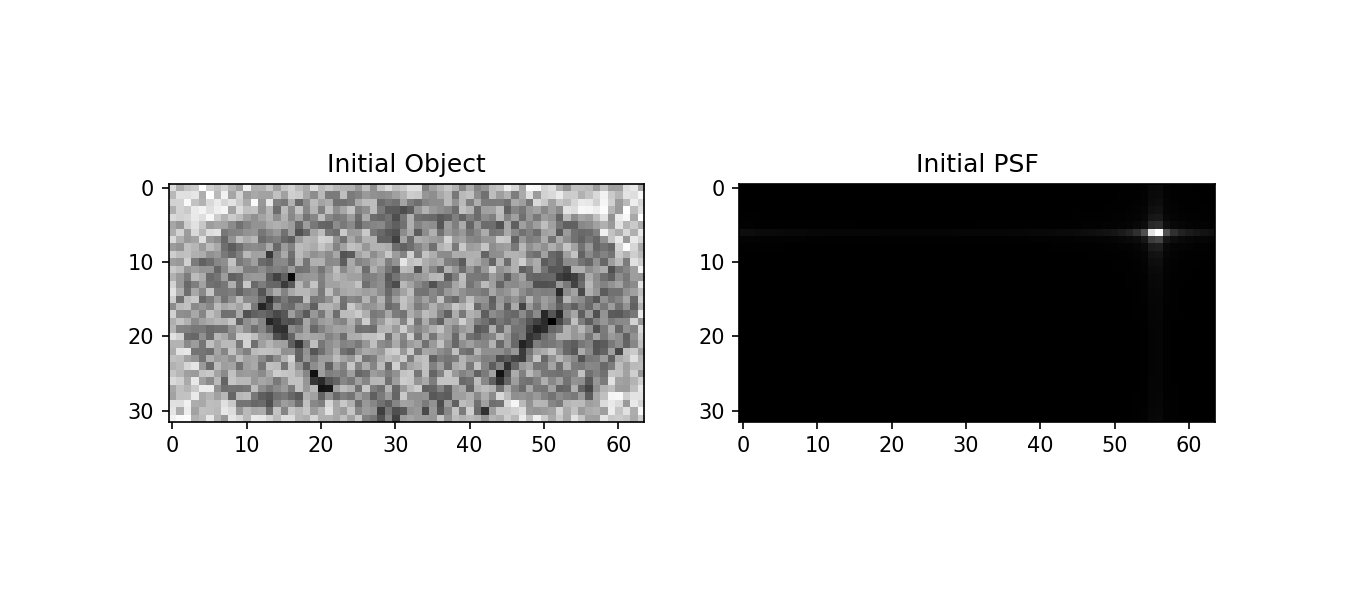

In [6]:
# Generate true shift
h = F.H * H * shift_recon

# Show object and psf
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(np.abs(object_recon.reshape(object_true.shape)), cmap='gray')
plt.title('Initial Object')
plt.subplot(122)
plt.imshow(np.abs((h).reshape(image_size)), cmap='gray')
plt.title('Initial PSF')

In [7]:
L2_op = ops.L2Norm(A_object.shape[0], A_object.dtype)


In [8]:
objective_object = L2_op * (A_object - y)
objective_shift = L2_op * (A_shift - y)


In [9]:
A_object_set_shift(shift_true);
A_shift_set_object(object_true.reshape(-1));


In [12]:
object_recon, shift_recon = iterative.AlternatingGradient([objective_object, objective_shift], 
                                                          [A_object_set_shift, A_shift_set_object], [2,1],
                                                          initializations = [object_recon.reshape(-1), shift_recon])

Solving function:


<IPython.core.display.Latex object>

Solving function:


<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


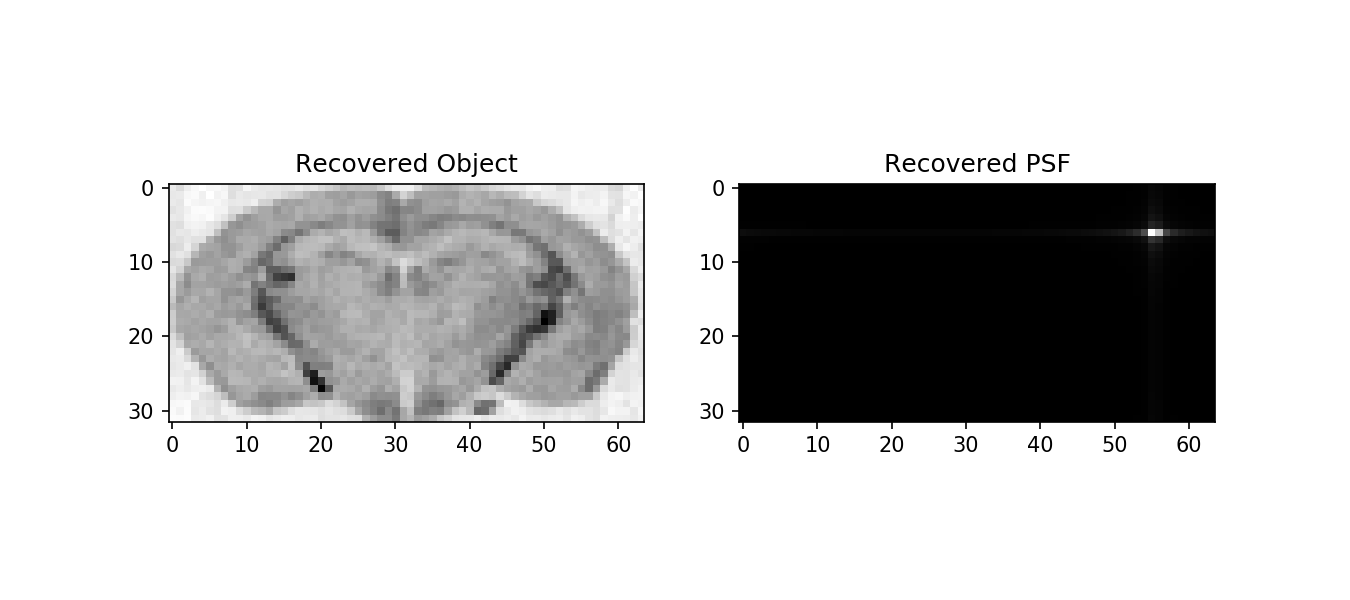

In [13]:

# Generate psf from shift
h = F.H * H * shift_recon

# Show object and psf
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(np.abs(object_recon.reshape(object_true.shape)), cmap='gray')
plt.title('Recovered Object')
plt.subplot(122)
plt.imshow(np.abs((h).reshape(image_size)), cmap='gray')
plt.title('Recovered PSF')